In [1]:
import random
from datetime import datetime

# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# %config Completer.use_jedi = False

In [6]:
data = pd.read_csv(r'../sample_timeseries_daily.csv',
                 dtype={"ds": str,"store_id": str,"item_id":str,"y": float,"x": float,"holiday": int,"month": int,"weekday": int},
                 parse_dates=["ds"]
)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        547 non-null    datetime64[ns]
 1   store_id  547 non-null    object        
 2   item_id   547 non-null    object        
 3   y         547 non-null    float64       
 4   x         547 non-null    float64       
 5   holiday   547 non-null    int32         
 6   month     547 non-null    int32         
 7   weekday   547 non-null    int32         
dtypes: datetime64[ns](1), float64(2), int32(3), object(2)
memory usage: 27.9+ KB


In [8]:
# INDEX
data = data.set_index(data.ds)
data = data.drop("ds", axis=1)
data = data.asfreq('D')

In [9]:
# Split train-val-test
# ==============================================================================
end_train = '2019-12-31'
end_validation = '2020-03-31'
end_test = '2020-06-30'

In [13]:
# exog
exog_variables = [column for column in data.columns
                      if column.startswith(('holiday', 'month', 'weekday'))]
exog_variables.extend(['x'])

print(exog_variables)

['holiday', 'month', 'weekday', 'x']


In [14]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
regressor = LGBMRegressor(random_state=123),
lags = 30
)

In [16]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [31,32,33,34,35]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data[:end_validation]['y'],
                        exog               = data[:end_validation][exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 31,
                        refit              = True,
                        metric             = 'mean_absolute_error',
                        initial_train_size = int(len(data[:end_train])),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                        )

Number of models compared: 60.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [00:22<00:00,  4.52s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.745342362212266



In [17]:
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3, n_estimators=500, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for y: None 
Transformer for exog: None 
Window size: 32 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['holiday', 'month', 'weekday', 'x'] 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2020-03-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'sub

In [18]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data[:end_test]['y'],
    exog               = data[:end_test][exog_variables],
    initial_train_size = len(data[:end_validation]),
    fixed_train_size   = False,
    steps              = 91,
    refit              = False,
    metric             = 'mean_absolute_error',
    verbose            = True
    )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 456
Number of observations used for backtesting: 91
    Number of folds: 1
    Number of steps per fold: 91

Data partition in fold: 0
    Training:   2019-01-01 00:00:00 -- 2020-03-31 00:00:00  (n=456)
    Validation: 2020-04-01 00:00:00 -- 2020-06-30 00:00:00  (n=91)



,pred
2020-04-01,10.329288
2020-04-02,10.618144
2020-04-03,10.515382
2020-04-04,10.842006
2020-04-05,10.701866


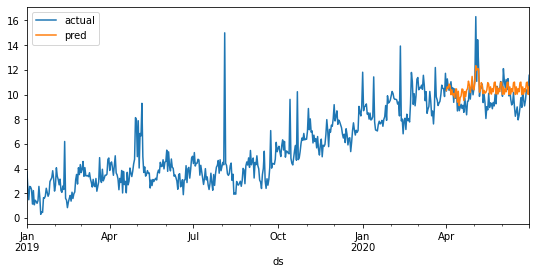

In [19]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data[:end_test].y.plot(ax=ax, label='actual')
predictions[:end_test].plot(ax=ax, label='predictions')
ax.legend();

In [20]:
#forecast.predict
# ==============================================================================
steps = 91
predictions_steps = forecaster.predict(
    last_window=data[:end_validation]["y"],
    exog = data[:end_test][exog_variables],
    steps=steps
)

predictions_steps.head()

2020-04-01    9.717084
2020-04-02    8.018262
2020-04-03    7.978900
2020-04-04    7.677499
2020-04-05    8.140795
Freq: D, Name: pred, dtype: float64

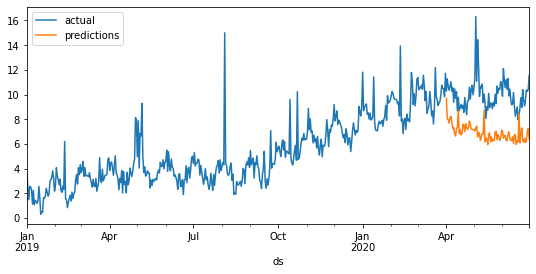

In [21]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data[:end_test].y.plot(ax=ax, label='actual')
predictions_steps.plot(ax=ax, label='predictions')
ax.legend();